
# Step 0.2: Clean up the Yelp dataset

This notebook cleans up the yelp dataset and converts the JSON files into tidy tabular data in CSV format.

The steps we have taken:

- The nested JSON objects about business categories, attributes and hours are flattened as separate columns.
- Each business is assigned a neighborhood and a census tract using spatial joins.
- Businesses are pruned to be only those within known neighborhoods.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.io.json import json_normalize

sns.set(
    style="white",
    color_codes=True,
    rc={
        'axes.linewidth': 0.5,
        'lines.linewidth': 2,
        'axes.labelsize': 14,
        'axes.titlesize': 14
    }
)

pd.set_option('display.max_rows', 3)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Businesses

### Load data

In [2]:
business_path = '../../../yelp-data/business.json'
business_json = [json.loads(line) for line in open(business_path)]
business_df = pd.DataFrame(business_json)
business_df

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,691 Richmond Rd,"{'RestaurantsPriceRange2': 2, 'BusinessParking...",YDf95gJZaq05wvo7hTQbbQ,"[Shopping, Shopping Centers]",Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,41.541716,-81.493116,Richmond Town Square,,44143,17,2.0,OH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,540 Marks St,"{'BusinessAcceptsCreditCards': True, 'Restaura...",scMIE4jyGp7FkWrMKAgjxA,"[Fashion, Shopping, Food, Department Stores, M...",Henderson,{},0,36.060708,-115.033241,Walmart,,89014,42,2.5,NV


### Categories

First, let's check what are the top categories.

In [3]:
from collections import Counter

cat_count = Counter(json_normalize(business_json, ['categories'])[0].values)
cat_count = pd.DataFrame(cat_count.most_common(), columns=['category', 'count'])

pd.set_option('display.max_rows', 20)
print('Total {} categories'.format(cat_count.shape[0]))
display(cat_count[:20])
pd.set_option('display.max_rows', 2)

Total 1240 categories


,category,count
0,Restaurants,51613
1,Shopping,24595
2,Food,23014
3,Beauty & Spas,15139
4,Home Services,13202
5,Health & Medical,12033
6,Nightlife,11364
7,Bars,9868
8,Automotive,9476
9,Local Services,9343


Following graph shows the distribution of business count among all 1240 categories.

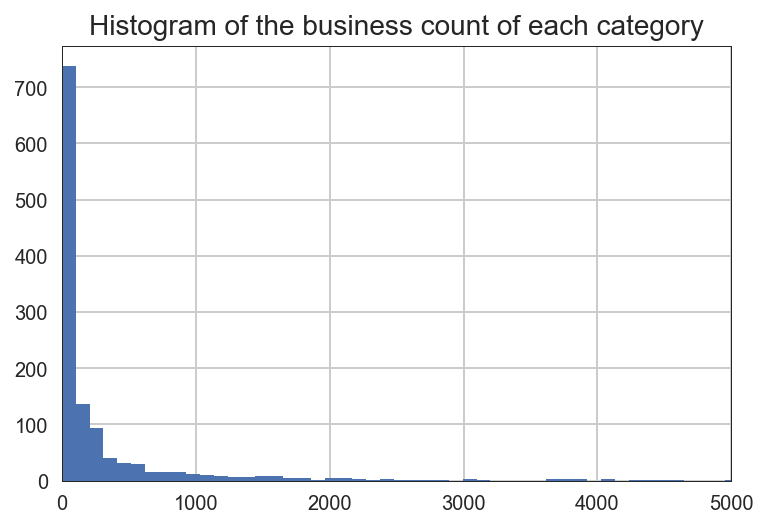

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
plt.xlim([0, 5000])
cat_count.hist(bins=500, ax=ax)
plt.title('Histogram of the business count of each category')

More than half (700+) categories have less than 10 businesses. We would only want to keep the most popular ones. First, check which root levels have the most businesses. Let me guess, restaurants?

In [5]:
# All Yelp categories, downloaded from https://www.yelp.com/developers/documentation/v3/category_list
categories = json.loads(open('../data/step0/categories.json').read())

id2cat = {
    x['alias']: x
    for x in categories
}

def cat_level(x, level=0):
    if len(x['parents']) == 0:
        return level + 1
    for parent in x['parents']:
        parent = id2cat[parent]
        return cat_level(parent, level + 1)
    
# The root categories
root_categories = [x['title'] for x in categories if len(x['parents']) == 0]

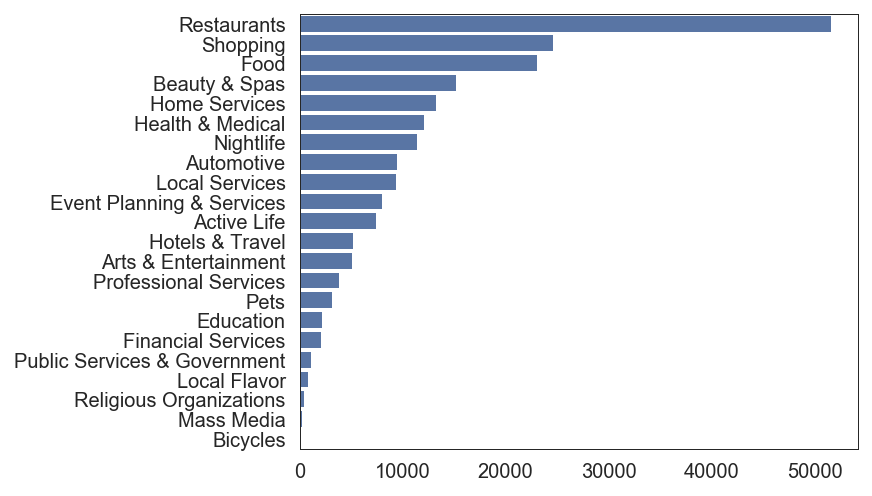

In [6]:
def plot_category_count(records):
    cat_count = Counter(json_normalize(records, ['categories'])[0].values)
    cat_count = pd.DataFrame(cat_count.most_common(), columns=['category', 'count'])
    root_cat_count = cat_count[cat_count['category'].isin(root_categories)]
    fig, ax = plt.subplots(figsize=(5,4))
    g = sns.categorical.barplot(
        y='category',
        x='count',
        color='b',
        data=root_cat_count)
    # g.set_title('Number of businesses in top-level Categories')
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    return fig, cat_count, root_cat_count

fig, cat_count, root_cat_count = plot_category_count(business_json)
fig.savefig('../tex/categories.pdf', bbox_inches='tight')

Restaurants indeed is the the category with most businesses. Let's use the top categories to build a feature matrix.

In [7]:
# In addition to the root categories, we would want some secondary categories in restaurants and food, too.
restfood_cats = [
    x['title'] for x in categories
    if 'restaurants' in x['parents'] or 'food' in x['parents']
]
pd.set_option('display.max_rows', 40)
restfood_cat_count = (
    cat_count[cat_count['category'].isin(restfood_cats)]
    .reset_index().drop('index', axis=1)
)
display(restfood_cat_count[:40])
pd.set_option('display.max_rows', 2)

,category,count
0,Sandwiches,5864
1,Fast Food,5792
2,American (Traditional),5737
3,Pizza,5652
4,Coffee & Tea,5565
5,Italian,4411
6,Burgers,4236
7,Breakfast & Brunch,4103
8,Mexican,3913
9,American (New),3802


In [8]:
pop_cats = set(root_cat_count['category'][:15])  # Till "Arts & Entertainment"
pop_cats |= set(restfood_cat_count['category'][:40])
biz_cats = [
    {item: True for item in set(x['categories']) & pop_cats}
    for x in business_json
]
biz_cats = json_normalize(biz_cats)
biz_cats

,Active Life,American (New),American (Traditional),Arts & Entertainment,Asian Fusion,Automotive,Bakeries,Barbeque,Beauty & Spas,Breakfast & Brunch,...,Salad,Sandwiches,Seafood,Shopping,Specialty Food,Steakhouses,Sushi Bars,Thai,Vegetarian,Vietnamese
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN


Some restaurants may say something about a neighborhood. Let's create two variables, one indicating Asian food, one indicating cafes and brunch.

Then we create a new DataFrame with the flattened categories information. In the mean time, drop `categories`, `attributes` and `hours`, too. We will add them back later.

In [9]:
biz_df = pd.concat([business_df.drop(['categories', 'attributes', 'hours'], axis=1), biz_cats], axis=1)
biz_df

,address,business_id,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,...,Salad,Sandwiches,Seafood,Shopping,Specialty Food,Steakhouses,Sushi Bars,Thai,Vegetarian,Vietnamese
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,Richmond Heights,1,41.541716,-81.493116,Richmond Town Square,,44143,17,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,540 Marks St,scMIE4jyGp7FkWrMKAgjxA,Henderson,0,36.060708,-115.033241,Walmart,,89014,42,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN


### Attributes

Attributes are amenities or extra services businesses provide, are often telling of how "upscale" a business is. We suspect most attributes are only available to restaurants, as Yelp is regarded as mostly a review website for restaurants. Let's verify whether that is true.

In [10]:
biz_attrs = json_normalize(business_df.to_dict('list'), ['attributes'])

# proportion of businesses with the attribute set
top_attrs = biz_attrs.isnull().agg('mean').sort_values()

print('Total number of attributes: {}'.format(len(top_attrs)))

pd.set_option('display.max_rows', 50)
display(top_attrs)
pd.set_option('display.max_rows', 3)

Total number of attributes: 39


BusinessAcceptsCreditCards    0.229113
RestaurantsPriceRange2        0.384859
BusinessParking               0.429012
BikeParking                   0.530768
GoodForKids                   0.627411
RestaurantsTakeOut            0.651121
OutdoorSeating                0.678816
RestaurantsGoodForGroups      0.683170
RestaurantsDelivery           0.701205
RestaurantsReservations       0.702992
RestaurantsAttire             0.713909
Alcohol                       0.717567
WheelchairAccessible          0.718952
HasTV                         0.720836
WiFi                          0.722745
GoodForMeal                   0.725790
Ambience                      0.726122
NoiseLevel                    0.740467
RestaurantsTableService       0.744885
ByAppointmentOnly             0.777942
Caters                        0.779538
DogsAllowed                   0.928409
BusinessAcceptsBitcoin        0.943335
AcceptsInsurance              0.945250
GoodForDancing                0.945524
HappyHour                

In [11]:
top_attrs[top_attrs >= 0.9]

DogsAllowed            0.928409
                         ...   
DietaryRestrictions    0.998410
Length: 18, dtype: float64

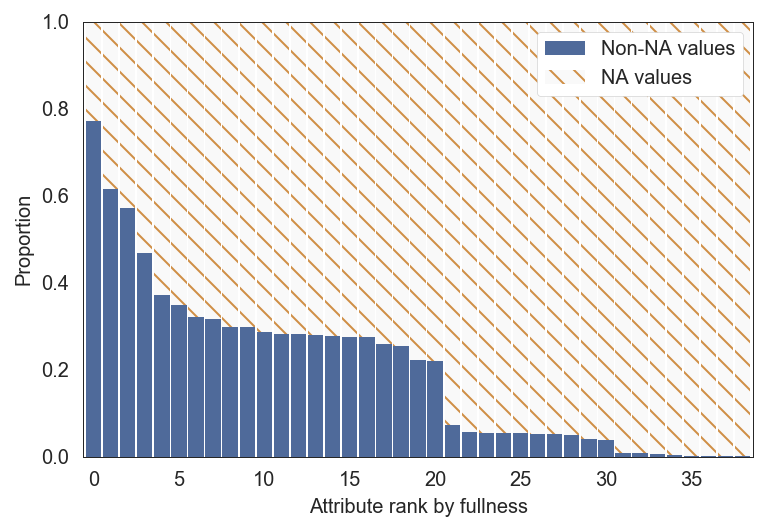

In [12]:
fig, ax = plt.subplots()
has_var = 1 - top_attrs
g1 = has_var.plot.bar(width=0.9, ax=ax, color='#4f6a9a', label='Non-NA values')
g = top_attrs.plot.bar(width=0.9, ax=ax, bottom=has_var, hatch='\\\\', color='#f9f9f9', edgecolor='#cf8f46', lw=0, label='NA values')
g.set_xticks(range(0, len(top_attrs), 5))
g.set_xticklabels(range(0, len(top_attrs), 5), rotation=0)
g.set_xlabel('Attribute rank by fullness', size=10)
g.set_ylabel('Proportion', size=10)
g.set_ylim((0, 1))
g.set_xlim((-0.6, 38.6))
g.legend(loc='upper right', frameon=True, framealpha=1, facecolor='#ffffff')
fig.savefig('../tex/attributes.pdf', bbox_inches='tight')

Above series displays the proportion of businesses that do not have this attribute set.
We would pick only the top attributes, and attach them to the business data frame.

In [13]:
useful_attrs = [
    'BusinessAcceptsCreditCards',
    'BikeParking',
    'GoodForKids',
    'OutdoorSeating',
    'RestaurantsPriceRange2',
    'RestaurantsGoodForGroups',
    'RestaurantsDelivery',
    'RestaurantsTakeOut',
    'RestaurantsReservations',
    'RestaurantsAttire',
    # these two are more intricate, and need additional work
    # 'GoodForMeal',
    # 'Ambience',
    'Alcohol'
]

# add attributes as columns
for attr_name in useful_attrs:
    biz_df[attr_name] = biz_attrs[attr_name]
biz_df

,address,business_id,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,...,BikeParking,GoodForKids,OutdoorSeating,RestaurantsPriceRange2,RestaurantsGoodForGroups,RestaurantsDelivery,RestaurantsTakeOut,RestaurantsReservations,RestaurantsAttire,Alcohol
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,Richmond Heights,1,41.541716,-81.493116,Richmond Town Square,,44143,17,...,True,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,540 Marks St,scMIE4jyGp7FkWrMKAgjxA,Henderson,0,36.060708,-115.033241,Walmart,,89014,42,...,True,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


### Hours

The oepning hours of businesses are also in a nested json object. We convert them to three variables:

- Total opening hours in weekdays
- Total opening hours in weekends
- Opening till late night---whether the business stays open at least till 8pm.

In [14]:
from datetime import datetime

def parse_hours(hours):
    FMT = '%H:%M'
    start, end = hours.split("-")    
    start, end = datetime.strptime(start, FMT), datetime.strptime(end, FMT)
    diff = (end - start).total_seconds() / 3600
    if diff <= 0: diff += 24
    return diff, start, end

weekends = ['Saturday', 'Sunday']
def extract_hours_vars(hours):
    wday_hrs, wend_hrs, is_late = 0, 0, False
    for day, day_hours in hours.items():
        diff, start, end = parse_hours(day_hours)
        if day in weekends:
            wend_hrs += diff
        else:
            wday_hrs += diff
        # if any day opens at least till 8 o'clock
        if end.hour > 19:
            is_late = True
    return wday_hrs, wend_hrs, is_late

biz_wday_hrs, biz_wend_hrs, biz_open_till_late = [], [], []
for x in business_json:
    wday_hrs, wend_hrs, is_late = extract_hours_vars(x['hours'])
    biz_wday_hrs.append(wday_hrs)
    biz_wend_hrs.append(wend_hrs)
    biz_open_till_late.append(is_late)
    
biz_df['wday_hrs'] = biz_wday_hrs
biz_df['wend_hrs'] = biz_wend_hrs
biz_df['open_till_late'] = biz_open_till_late
biz_df

,address,business_id,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,...,RestaurantsPriceRange2,RestaurantsGoodForGroups,RestaurantsDelivery,RestaurantsTakeOut,RestaurantsReservations,RestaurantsAttire,Alcohol,wday_hrs,wend_hrs,open_till_late
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,Richmond Heights,1,41.541716,-81.493116,Richmond Town Square,,44143,17,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,55.0,18.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,540 Marks St,scMIE4jyGp7FkWrMKAgjxA,Henderson,0,36.060708,-115.033241,Walmart,,89014,42,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False


It can be verified that all records have the hours info available.

In [15]:
business_df.hours.isnull().mean()

0.0

## Data Pruning

The Yelp dataset has businesses from 1,010 different cities (including duplicate city names due to spelling inconsistencies). It would be impracticable to collect neighborhood characteristics data for all of these citiess. Since more than 70% of the businesses are located in the US, we will focus on US cities only.

Since geographical boundaries data are distributed by states, and some metropolitan areas may encompass multiple cities---both large and small ones, we are filtering the businesses by selecting top states with most businesses, instead of top cities.

In [16]:
pd.set_option('display.max_rows', 15)

# Top 15 states with most businesses
display(biz_df['state'].value_counts()[:15])
pd.set_option('display.max_rows', 2)

AZ     47376
NV     30571
ON     26520
NC     11299
OH     10930
PA      8916
QC      7273
WI      4190
EDH     3561
BW      3071
IL      1667
SC       583
MLN      185
HLD      175
FIF       73
Name: state, dtype: int64

In [17]:
us_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

print(pd.DataFrame(biz_df[biz_df['state'].isin(us_states)]['state'].value_counts()[:7]).T.to_latex())
print(pd.DataFrame(biz_df[biz_df['state'].isin(us_states)]['state'].value_counts()[7:14]).T.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &     AZ &     NV &     NC &     OH &    PA &    WI &    IL \\
\midrule
state &  47376 &  30571 &  11299 &  10930 &  8916 &  4190 &  1667 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrr}
\toprule
{} &   SC &  NY &  CA &  WA &  AL &  FL &  NE \\
\midrule
state &  583 &  15 &   6 &   3 &   2 &   1 &   1 \\
\bottomrule
\end{tabular}



In [18]:
display(pd.DataFrame(biz_df[biz_df['state'].isin(us_states)]['state'].value_counts()[:7]).T)
display(pd.DataFrame(biz_df[biz_df['state'].isin(us_states)]['state'].value_counts()[7:14]).T)

,AZ,NV,NC,OH,PA,WI,IL
state,47376,30571,11299,10930,8916,4190,1667


,SC,NY,CA,WA,AL,FL,NE
state,583,15,6,3,2,1,1


The top US states with most businesses are AZ, NV, NC, OH, PA, WI, IL, SC. Since some records may have incorrect state information set, but it is relatively rare to have incorrect geolocation recorded, we used neighborhood boundaries of aforementioned states and spatial join to filter businesses, instead of filtering them by the `state` column.

### Prune businesses by neighborhoods

Following is the combined GeoDataFrame of the neighborhood boundaries of all 8 states (See `0.2_GeoSpatial.ipynb`).

The Yelp dataset has a "neighborhood" field for businesses, but only about 40% of them have values for this field.

In [19]:
(biz_df['neighborhood'] != '').mean()

0.39732122906811201

In [20]:
import geopandas as gpd

nbh = gpd.read_file('../data/step0/zillow-neighborhoods-all')

In [21]:
from shapely.geometry import Point

def to_geo_df(df, crs=None):
    """
    Convert a DF with longitude/latitude to a geo data frame.
    """
    df = df[df['longitude'].notnull()]
    points = [Point((x['longitude'], x['latitude'])) for x in df.to_records('list')]
    df = df.drop(['longitude', 'latitude'], axis=1)
    # CRS is the parameter for projection method
    return gpd.GeoDataFrame(df, crs=crs, geometry=points)
    
biz_geo_df = to_geo_df(biz_df, nbh.crs)
biz_geo_df

,address,business_id,city,is_open,name,neighborhood,postal_code,review_count,stars,state,...,RestaurantsGoodForGroups,RestaurantsDelivery,RestaurantsTakeOut,RestaurantsReservations,RestaurantsAttire,Alcohol,wday_hrs,wend_hrs,open_till_late,geometry
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,Richmond Heights,1,Richmond Town Square,,44143,17,2.0,OH,...,NaN,NaN,NaN,NaN,NaN,NaN,55.0,18.0,True,POINT (-81.4931165 41.5417162)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,540 Marks St,scMIE4jyGp7FkWrMKAgjxA,Henderson,0,Walmart,,89014,42,2.5,NV,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False,POINT (-115.0332406 36.0607079)


The full dataset has 156,638 businesses with geo-coordinates set, we use spatial join to filter out those in the known neighborhoods of our selected states.

In [22]:
biz_with_nbh = gpd.sjoin(biz_geo_df, nbh, how="inner", op='intersects')

# Titled columns are from Zillow neighborhoods,
# columns with all small cases are from Yelp businesses
# remove geo columns from the Yelp data, because we trust Zillow neighborhoods more
biz_with_nbh = biz_with_nbh.drop(['state','city', 'neighborhood', 'index_right'], axis=1)

biz_with_nbh

,address,business_id,is_open,name,postal_code,review_count,stars,Active Life,American (New),American (Traditional),...,wend_hrs,open_till_late,geometry,State,County,City,Name,RegionID,Nhood,Nhood_area
1,2824 Milton Rd,mLwM-h2YhXl2NCgdS84_Bw,0,South Florida Style Chicken & Ribs,28215,4,4.5,NaN,NaN,NaN,...,24.0,True,POINT (-80.7419759 35.23687),NC,Mecklenburg,Charlotte,Oak Forest,274830,"Oak Forest, Charlotte, NC",3.580327e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154973,310 N Cottonwood Dr,5vU5jW8cOA0EM4ti9Bm-sg,1,Home Dog Training Positively,85234,4,5.0,NaN,NaN,NaN,...,20.0,False,POINT (-111.7857523 33.3557544),AZ,Maricopa,Gilbert,Stonebridge Lakes,417611,"Stonebridge Lakes, Gilbert, AZ",4.514141e+05


In [23]:
print('Number of neighborhoods: ', biz_with_nbh['Nhood'].unique().size)
print('Number of businesses before reduction:', biz_geo_df.shape[0])
print('Number of businesses after reduction:', biz_with_nbh.shape[0])
print('{} / {} = {:.2%}'.format(
    biz_with_nbh.shape[0], biz_geo_df.shape[0],
    biz_with_nbh.shape[0] / biz_geo_df.shape[0]
))

Number of neighborhoods:  792
Number of businesses before reduction: 156638
Number of businesses after reduction: 71308
71308 / 156638 = 45.52%


After pruning by states and neighborhoods, the number of businesses dropped nearly 55%.
To ensure a fair comparison, we shall be careful with neighborhoods with few businesses, too.
While one may argue these neighorhoods may be residential areas, and should be a legitimate neighborhood type to compare with others, we shall at least put them into a separate group before clustering, so that they would not
stop us from telling neighborhoods with different tyeps of businesses apart.

The distribution of business count by neighborhoods tells us how much should the additional pruning applies.

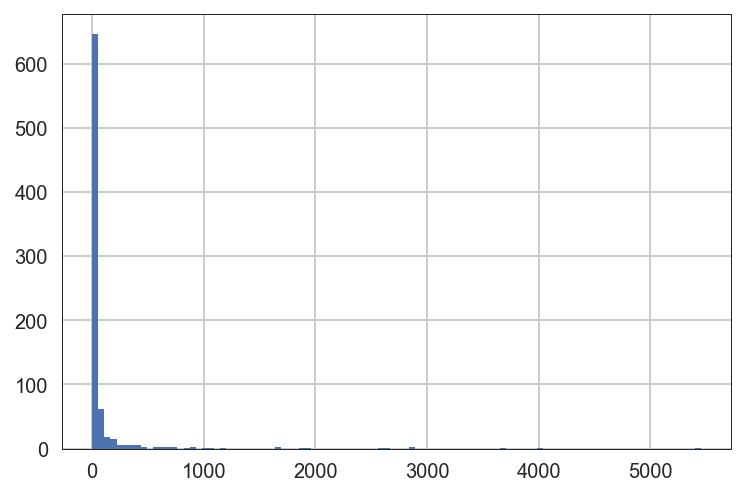

In [24]:
nbh_biz_count = (
    biz_with_nbh.groupby('Nhood')
    .agg({'business_id': ['count']})
    [('business_id', 'count')]
    .sort_values(ascending=False)
)
g = nbh_biz_count.hist(bins=100)

In [25]:
pd.DataFrame(nbh_biz_count.quantile([0, 0.25, 0.5, 0.75, 1])).T

,,0.0,0.25,0.5,0.75,1.0
business_id,count,1.0,3.0,13.0,38.0,5454.0


About half of the neighborhoods have less than 13 businesses. While it may be safe to say those are mostly residential or industrial areas, having no businesses within the neighborhood does not mean they do not have access to businesses nearby. To be more flexible in future analysis, we are assigning each record in the business table the total number of businesses in its neighborhood, instead of excluding these businesses and neighborhoods for good. 

In [26]:
# add neighborhood biz count information for each of filtering
biz_with_nhood =  biz_with_nbh.merge(pd.DataFrame({
    'Nhood': nbh_biz_count.index,
    'Nhood_biz_count': nbh_biz_count.values
}), on='Nhood')

display(biz_with_nhood)

,address,business_id,is_open,name,postal_code,review_count,stars,Active Life,American (New),American (Traditional),...,open_till_late,geometry,State,County,City,Name,RegionID,Nhood,Nhood_area,Nhood_biz_count
0,2824 Milton Rd,mLwM-h2YhXl2NCgdS84_Bw,0,South Florida Style Chicken & Ribs,28215,4,4.5,NaN,NaN,NaN,...,True,POINT (-80.7419759 35.23687),NC,Mecklenburg,Charlotte,Oak Forest,274830,"Oak Forest, Charlotte, NC",3.580327e+06,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71307,310 N Cottonwood Dr,5vU5jW8cOA0EM4ti9Bm-sg,1,Home Dog Training Positively,85234,4,5.0,NaN,NaN,NaN,...,False,POINT (-111.7857523 33.3557544),AZ,Maricopa,Gilbert,Stonebridge Lakes,417611,"Stonebridge Lakes, Gilbert, AZ",4.514141e+05,1


We can always impose different threshold for business count later when we aggregate measurements by neighborhoods. Following is the number of neighborhoods we can get when applying different thresholds.

In [27]:
thresholds = [0, 5, 10, 20]
for x in thresholds:
    print('business count >= {: <2d}  :  {} neighborhoods'.format(
        x, nbh_biz_count[nbh_biz_count >= x].size
    ))

business count >= 0   :  792 neighborhoods
business count >= 5   :  545 neighborhoods
business count >= 10  :  442 neighborhoods
business count >= 20  :  315 neighborhoods


### Export pruned shapefile for neighborhoods

However, we can at least discard neighborhoods without any business at all.

In [28]:
# neighborhoods with businesses
active_nbhs = biz_with_nbh['Nhood'].unique()
nbh_with_biz = nbh[nbh['Nhood'].isin(active_nbhs)]

print('Total # of neighborhoods:', nbh['Nhood'].unique().size)
print('# of neighborhoods with businesses:', active_nbhs.size)

Total # of neighborhoods: 3353
# of neighborhoods with businesses: 792


In [29]:
display(nbh_with_biz)
nbh_with_biz.to_file('../data/step1/neighborhoods')

,State,County,City,Name,RegionID,Nhood,Nhood_area,geometry
index_right,,,,,,,,
0,AZ,Maricopa,Gilbert,Highland,256336,"Highland, Gilbert, AZ",85807.054247,POLYGON ((-111.7123999999999 33.29793137600003...
...,...,...,...,...,...,...,...,...
3304,WI,Dane,Madison,Park Ridge,343591,"Park Ridge, Madison, WI",122734.946413,POLYGON ((-89.50231126699993 43.04039536700012...


We reduced the 3,353 neighborhoods in 8 states to 792 neighborhoods with at least one business--that's throwing off 77% of the original data. The reason of such drastic reduction is that the Yelp dataset is not complete, and there are a lot of residential neighborhoods naturally would not have many businesses.

Let's zoom in to Las Vegas to see how neighborhood boundaries overlay with the Yelp businesses.

### Prune businesses by census tracts

While it is possible to estimate demographic variables for neighborhoods, by checking how do they overlap with census tracts, it introduces another layer of noises. We might as well simply use census tracts to aggregate measurements for Yelp businesses. To do so, we would need to assign each business a census tract ID, just like we did for the neighborhoods.

In [30]:
tract = gpd.read_file('../data/step0/census-tracts-all')

biz_with_tract = gpd.sjoin(biz_geo_df, tract, how="inner", op='intersects')
biz_with_tract = biz_with_tract.drop(['state','city', 'neighborhood', 'index_right'], axis=1)

biz_with_tract

,address,business_id,is_open,name,postal_code,review_count,stars,Active Life,American (New),American (Traditional),...,Alcohol,wday_hrs,wend_hrs,open_till_late,geometry,STATEFP,COUNTYFP,CT_ID,CT_LAND,CT_WATER
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,1,Richmond Town Square,44143,17,2.0,NaN,NaN,NaN,...,NaN,55.0,18.0,True,POINT (-81.4931165 41.5417162),39,035,39035180102,4183953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155598,,LPs4gqPdVHt0cYMSWI8TPw,1,Mr. Electric of Northeast Ohio & Columbus,44070,7,3.0,NaN,NaN,NaN,...,NaN,75.0,24.0,True,POINT (-83.0908883386 40.1735679142),39,041,39041011900,8842627,641205


In [31]:
tract_biz_count = (
    biz_with_tract.groupby('CT_ID')
    .agg({'business_id': ['count']})
    [('business_id', 'count')]
    .sort_values(ascending=False)
)
biz_with_ct =  biz_with_tract.merge(pd.DataFrame({
    'CT_ID': tract_biz_count.index,
    'CT_BIZ_COUNT': tract_biz_count.values
}), on='CT_ID')

display(biz_with_ct)

,address,business_id,is_open,name,postal_code,review_count,stars,Active Life,American (New),American (Traditional),...,wday_hrs,wend_hrs,open_till_late,geometry,STATEFP,COUNTYFP,CT_ID,CT_LAND,CT_WATER,CT_BIZ_COUNT
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,1,Richmond Town Square,44143,17,2.0,NaN,NaN,NaN,...,55.0,18.0,True,POINT (-81.4931165 41.5417162),39,035,39035180102,4183953,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115518,,LPs4gqPdVHt0cYMSWI8TPw,1,Mr. Electric of Northeast Ohio & Columbus,44070,7,3.0,NaN,NaN,NaN,...,75.0,24.0,True,POINT (-83.0908883386 40.1735679142),39,041,39041011900,8842627,641205,1


### Merge CT and Nhood

In [32]:
biz = (
    biz_geo_df.merge(
        biz_with_ct.loc[:, ['business_id', 'CT_ID', 'CT_LAND', 'CT_WATER', 'CT_BIZ_COUNT']],
        how='outer',
        on='business_id'
    )
    .merge(
        biz_with_nhood.loc[:, ['business_id', 'State', 'County', 'City', 'Name',
                               'Nhood', 'Nhood_area', 'Nhood_biz_count']],
        how='outer',
        on='business_id'
    )
)
biz = biz[biz['CT_ID'].notnull() | biz['Nhood'].notnull()]

display(biz)

,address,business_id,city,is_open,name,neighborhood,postal_code,review_count,stars,state,...,CT_LAND,CT_WATER,CT_BIZ_COUNT,State,County,City,Name,Nhood,Nhood_area,Nhood_biz_count
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,Richmond Heights,1,Richmond Town Square,,44143,17,2.0,OH,...,4183953.0,0.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156648,540 Marks St,scMIE4jyGp7FkWrMKAgjxA,Henderson,0,Walmart,,89014,42,2.5,NV,...,18327522.0,0.0,792.0,NV,Clark,Henderson,Whitney Ranch,"Whitney Ranch, Henderson, NV",7.521403e+06,577.0


Apparently, all businesses would have census tract ID, but not all of them have an associated neighborhood name. Let's confirm that.

In [33]:
from IPython.core.display import display, HTML

display(HTML('<h5>Businesses with either CT_ID or Nhood</h5>'))
display(biz.shape[0])

display(HTML('<h5>Businesses with CT_ID</h5>'))
display(biz[biz['CT_ID'].notnull()].shape[0])

display(HTML('<h5>Businesses with Nhood</h5>'))
display(biz[biz['Nhood'].notnull()].shape[0])

display(HTML('<h5>Businesses with Nhood but not CT_ID</h5>'))
display(biz[biz['Nhood'].notnull() & biz['CT_ID'].isnull()].shape[0])

115522

115522

71315

0

### Business density

With the help of the `PySal` library, we can calculate business density based on distance bands.

We add a metric `n_biz_in_2_km` indicating how many other businesses are within a radius of 2 kilometers for a business.

In [34]:
biz_test = biz.to_crs({'proj':'cea'})
points = [(p.x, p.y) for p in biz_test.geometry]
points[:5]

[(-9071772.23193692, 4209710.983250532),
 (-8988155.642830767, 3660723.878246068),
 (-12458476.692812169, 3507549.3436648473),
 (-12472107.441633282, 3502074.9265634357),
 (-12471963.282892704, 3502272.9933617306)]

In [35]:
from pysal.weights import DistanceBand
from pysal.cg.kdtree import KDTree

tree = KDTree(points)
w = DistanceBand(tree, 2000,
                 build_sp=True,
                 silent=True)
w = list(map(sum, w.weights.values()))
# business density weight: how many businesses are within 2km
biz['n_biz_in_2km'] = w

biz['longitude'] = [p.x for p in biz.geometry]
biz['latitude'] = [p.y for p in biz.geometry]
biz = biz.drop('geometry', axis=1)
biz

,address,business_id,city,is_open,name,neighborhood,postal_code,review_count,stars,state,...,State,County,City,Name,Nhood,Nhood_area,Nhood_biz_count,n_biz_in_2km,longitude,latitude
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,Richmond Heights,1,Richmond Town Square,,44143,17,2.0,OH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,-81.493116,41.541716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156648,540 Marks St,scMIE4jyGp7FkWrMKAgjxA,Henderson,0,Walmart,,89014,42,2.5,NV,...,NV,Clark,Henderson,Whitney Ranch,"Whitney Ranch, Henderson, NV",7.521403e+06,577.0,775.0,-115.033241,36.060708


In [36]:
# Export ...
biz.to_csv('../data/step1/biz.csv', index=False)

We can examine again how many businesses now have neighborhood information.

So, among all the businesses located in the 8 states we selected.

In [37]:
print('Yelp neighborhood: {:.2%} have values'.format((biz.neighborhood != '').mean()))
print('Zillow neighborhood: {:.2%} have values'.format((biz.Nhood.notnull()).mean()))

Yelp neighborhood: 30.33% have values
Zillow neighborhood: 61.73% have values


### Export pruned shapefile for census tracts

In [38]:
active_cts = biz_with_ct['CT_ID'].unique()
tract_with_biz = tract[tract['CT_ID'].isin(active_cts)]

print('Total # of census tracts:', tract['CT_ID'].unique().size)
print('# of census tracts with businesses:', active_cts.size)

display(tract_with_biz)

# Export ...
tract_with_biz.to_file('../data/step1/census-tracts')

Total # of census tracts: 16189
# of census tracts with businesses: 2981


,STATEFP,COUNTYFP,CT_ID,CT_LAND,CT_WATER,geometry
index_right,,,,,,
5,04,021,04021000206,23402094,0,"POLYGON ((-111.582918 33.248961, -111.563251 3..."
...,...,...,...,...,...,...
16163,55,085,55085970602,361158428,47247008,"POLYGON ((-89.575301 45.764998, -89.571539 45...."


## GeoSpatial Overlays: Las Vegas

In [39]:
from shapely.geometry import Polygon

nv_tract = tract[tract['STATEFP'] == '32']  # filter by State: Nevada
vegas_nbh = nbh[nbh['City'] == 'Las Vegas']
vegas_biz = biz_with_nbh[biz_with_nbh['City'] == 'Las Vegas']
bounds = vegas_nbh.total_bounds
vegas_box = gpd.GeoDataFrame({
    'geometry': 
        [Polygon([[bounds[0], bounds[1]], [bounds[0], bounds[3]],
                  [bounds[2], bounds[3]], [bounds[2], bounds[1]],])]
})
vegas_tract = gpd.overlay(nv_tract, vegas_box, how='intersection')

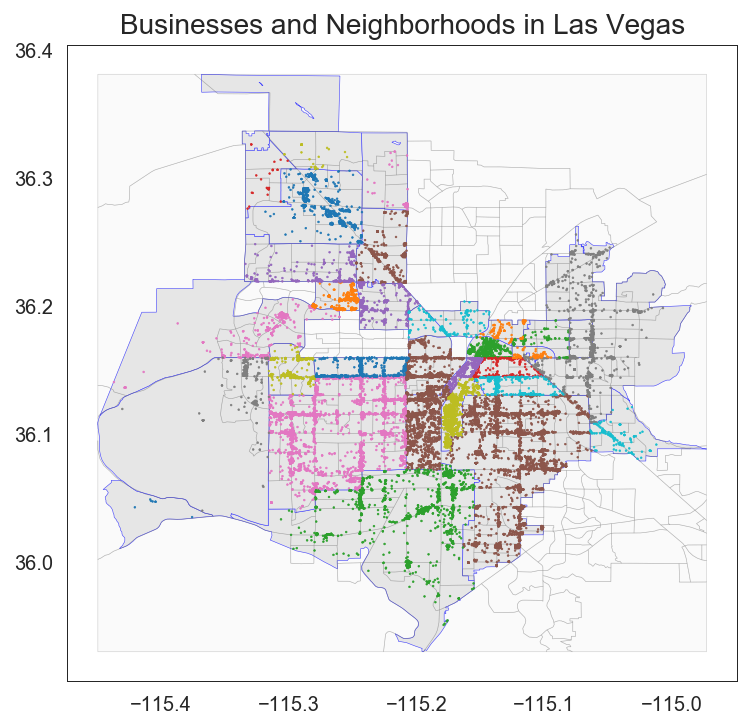

In [40]:
fig, ax = plt.subplots(
    figsize=(6,6),
    subplot_kw={
        'aspect':'equal'
    }
)
g1 = vegas_nbh.plot(color='#e3e3e3', edgecolor='blue', ax=ax)
g3 = vegas_tract.plot(color='#f0f0f0', edgecolor='#666666', ax=ax, alpha=0.3)
g2 = vegas_biz.plot(column='Nhood', markersize=0.8, ax=ax)
g2.set_title('Businesses and Neighborhoods in Las Vegas')
fig.savefig('../tex/las-vegas.pdf', bbox_inches = 'tight')

## Statistics for the reduced dataset


### Histogram of business count

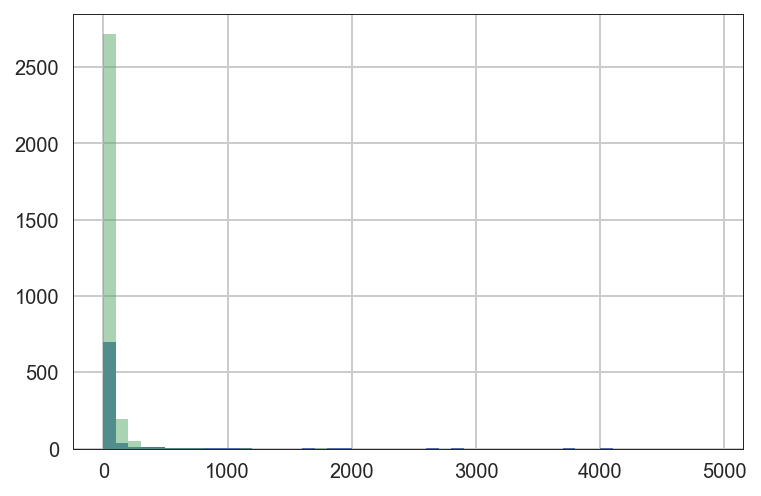

In [41]:
biz_count_by_nhood = biz['Nhood'].value_counts()
biz_count_by_ct = biz['CT_ID'].value_counts()

fig, ax = plt.subplots(
    figsize=(6,4),
)
bins = range(0, 5000, 100)
g1 = biz_count_by_nhood.hist(bins=bins, ax=ax)
g2 = biz_count_by_ct.hist(bins=bins, ax=ax, alpha=0.5)

In [42]:
biz_count_by_nhood.size, biz_count_by_ct.size

(792, 2981)

In [43]:
def get_quantiles(counts):
    ret = pd.DataFrame(counts.quantile([0, 0.25, 0.5, 0.75, 1]).astype(int)).T
    ret.columns = ret.columns.map(lambda x: f'{x:.0%}')
    return ret

counts = pd.concat([get_quantiles(biz_count_by_nhood), get_quantiles(biz_count_by_ct)])
display(counts)
print(counts.to_latex())

,0%,25%,50%,75%,100%
Nhood,1,3,13,38,5454
CT_ID,1,6,19,45,1767


\begin{tabular}{lrrrrr}
\toprule
{} &  0\% &  25\% &  50\% &  75\% &  100\% \\
\midrule
Nhood &   1 &    3 &   13 &   38 &  5454 \\
CT\_ID &   1 &    6 &   19 &   45 &  1767 \\
\bottomrule
\end{tabular}



### Top categories

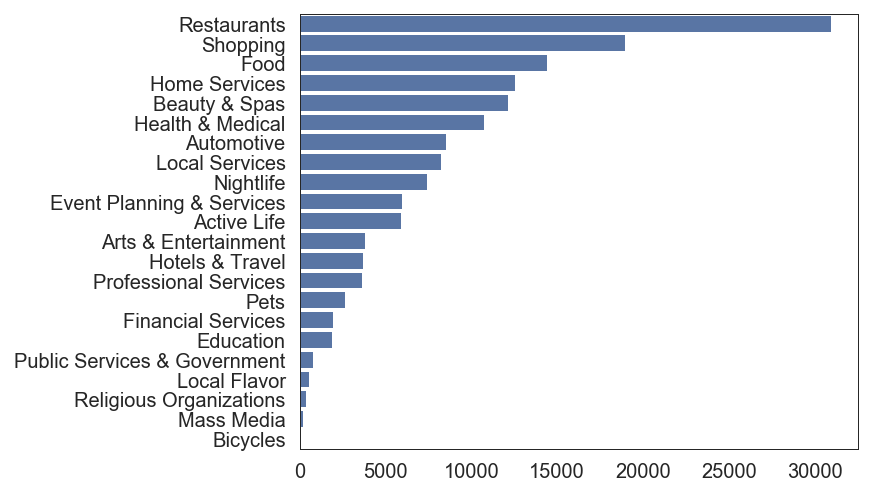

In [46]:
business_df_reduced = business_df[business_df['business_id'].isin(biz['business_id'].unique())]
fig, _, _ = plot_category_count(business_df_reduced.to_records('list'))
fig.savefig('../tex/categories.pdf', bbox_inches='tight')

We see more businesses in other categories when we reduced the dataset to US cities only. But the general trend is the same.